In [38]:
# google earth engine api
!pip install earthengine-api

In [51]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

In [54]:
# read geojson
# Load the GeoJSON file
#gdf = gpd.read_file('data/Tax_Parcels_2023.geojson')
#gdf.columns

Index(['OBJECTID', 'ParcelID', 'TaxYear', 'Address', 'AddrNumber',
       'AddrPreDir', 'AddrStreet', 'AddrSuffix', 'AddrPosDir', 'AddrUntTyp',
       'AddrUnit', 'Owner', 'OwnerAddr1', 'OwnerAddr2', 'TaxDist', 'TotAssess',
       'LandAssess', 'ImprAssess', 'TotAppr', 'LandAppr', 'ImprAppr', 'LUCode',
       'ClassCode', 'ExCode', 'LivUnits', 'LandAcres', 'NbrHood', 'Subdiv',
       'SubdivNum', 'SubdivLot', 'SubdivBlck', 'FeatureID', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')

In [11]:
'''

# 100 example
import geopandas as gpd

# Read the GeoJSON file
gdf = gpd.read_file('data/Tax_Parcels_2023.geojson')

# Take a subset of 100 features
gdf_100 = gdf.sample(n=100, random_state=42)

# Save the subset to a new GeoJSON file
gdf_100.to_file('gdf_100.geojson', driver='GeoJSON')

'''


KeyboardInterrupt: 

In [67]:
# export as csv
# Save the subset to a CSV file
# gdf_100.to_csv('newsample100.csv', index=False)

# df = pd.read_csv('data/newsample100.csv')

gdf = gpd.read_file('data/gdf_100.geojson')
gdf.columns

Index(['OBJECTID', 'ParcelID', 'TaxYear', 'Address', 'AddrNumber',
       'AddrPreDir', 'AddrStreet', 'AddrSuffix', 'AddrPosDir', 'AddrUntTyp',
       'AddrUnit', 'Owner', 'OwnerAddr1', 'OwnerAddr2', 'TaxDist', 'TotAssess',
       'LandAssess', 'ImprAssess', 'TotAppr', 'LandAppr', 'ImprAppr', 'LUCode',
       'ClassCode', 'ExCode', 'LivUnits', 'LandAcres', 'NbrHood', 'Subdiv',
       'SubdivNum', 'SubdivLot', 'SubdivBlck', 'FeatureID', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')

In [70]:
# Define a function to convert Polygon objects to coordinates
def polygon_to_coordinates(polygon):
    # Extract coordinates from the exterior of the polygon and convert them to the desired format
    coordinates = [[coord[0], coord[1]] for coord in polygon.exterior.coords]
    
    # Convert the list of coordinates to a string
    return str(coordinates)

# Apply the function to the entire 'geometry' column
gdf['geometry_coordinates'] = gdf['geometry'].apply(polygon_to_coordinates)

# Check the datatype of the new column
print(gdf['geometry_coordinates'].dtype)

gdf.geometry_coordinates.head()


object


0    [[-84.3661714914569, 33.7363611787858], [-84.3...
1    [[-84.4548307513653, 33.8139766035477], [-84.4...
2    [[-84.3940834742789, 33.6757407231616], [-84.3...
3    [[-84.3700271957561, 33.6934191447459], [-84.3...
4    [[-84.3509871792599, 33.7949783410319], [-84.3...
Name: geometry_coordinates, dtype: object

In [71]:
# convert and save it as csv 'newsample100.csv'
gdf.to_csv('newsample100.csv', index=False)

In [14]:
import ee

# Authenticate using your Google account
ee.Authenticate()



Successfully saved authorization token.


In [15]:
ee.Initialize()

In [16]:
import geopandas as gpd
import pandas as pd
import datetime



def export_image_to_drive(polygon_coords, start_date, end_date, vis_params, index, drive_folder_name='GEE_Images'):
    """
    Export an image to Google Drive with unique naming based on order.
    
    :param polygon_coords: Coordinates for the polygon defining the area of interest.
    :param start_date: Start date for the image collection filter.
    :param end_date: End date for the image collection filter.
    :param vis_params: Visualization parameters including 'min', 'max', and 'palette' if needed.
    :param index: Index of the polygon in the list, used for naming the file.
    :param scale: Scale in meters; 10 meters is a common scale for high-resolution satellite imagery.
    :param drive_folder_name: Google Drive folder name where the image will be saved.
    """
    roi = ee.Geometry.Polygon(polygon_coords)

    
    # Filter the ImageCollection
    image_collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
                        .filterBounds(roi) \
                        .filterDate(start_date, end_date)
    
    # Get the median image and clip to the ROI
    median_image = image_collection.median().clip(roi)
    
    # Unique description including the index
    unique_description = f'export_to_drive_{index:03d}'  # Zero padding for uniform naming
    
    # Setup the export parameters
    export_task = ee.batch.Export.image.toDrive(**{
        'image': median_image,
        'description': unique_description,
        'folder': drive_folder_name,
        'scale': (roi.area().getInfo() ** 0.5)/1024,
        'region': roi,
        'fileFormat': 'GEO_TIFF'
    })
    
    # Start the export task
    export_task.start()
    print(f"Export task started for {unique_description}. Check Google Drive folder:", drive_folder_name)



In [18]:
# Assuming the CSV file and dataframe loading code remains the same
# Example usage with a single polygon coordinates list from the CSV
csv_file_path = 'data/newsample100.csv'
df = pd.read_csv(csv_file_path)
geometry_coordinates_list = df['geometry_coordinates'].tolist()

# Visualization parameters for floating-point data
vis_params = {
    'min': 0.0,
    'max': 255.0,
    'format': 'png'
}

for index, polygon_coords_str in enumerate(geometry_coordinates_list):
    polygon_coords = eval(polygon_coords_str)  # Convert string to list
    
    # Call the function to export image to Google Drive with unique names
    export_image_to_drive(polygon_coords, '2018-01-01', '2023-12-31', vis_params, index, drive_folder_name='100samples111')

# After starting all tasks, check their status
import time
time.sleep(10)  # Wait a bit for all tasks to be registered

tasks = ee.batch.Task.list()
for task in tasks:
    if task.config['description'].startswith('export_to_drive_'):  # Adjust this if your naming pattern changes
        print(f"Task {task.config['description']} status:", task.status())

Export task started for export_to_drive_000. Check Google Drive folder: 100samples111
Export task started for export_to_drive_001. Check Google Drive folder: 100samples111
Export task started for export_to_drive_002. Check Google Drive folder: 100samples111
Export task started for export_to_drive_003. Check Google Drive folder: 100samples111
Export task started for export_to_drive_004. Check Google Drive folder: 100samples111
Export task started for export_to_drive_005. Check Google Drive folder: 100samples111
Export task started for export_to_drive_006. Check Google Drive folder: 100samples111
Export task started for export_to_drive_007. Check Google Drive folder: 100samples111
Export task started for export_to_drive_008. Check Google Drive folder: 100samples111
Export task started for export_to_drive_009. Check Google Drive folder: 100samples111
Export task started for export_to_drive_010. Check Google Drive folder: 100samples111
Export task started for export_to_drive_011. Check Goo

In [77]:
# get image date
import csv

def export_image_to_drive(polygon_coords, start_date, end_date, vis_params, index, drive_folder_name='GEE_Images'):
    # Code to export image to Google Drive (unchanged)
    ...
    
    # Return date of the image
    return end_date

# Assuming the CSV file and dataframe loading code remains the same
# Example usage with a single polygon coordinates list from the CSV
csv_file_path = 'data/newsample100.csv'
df = pd.read_csv(csv_file_path)
geometry_coordinates_list = df['geometry_coordinates'].tolist()

# Visualization parameters for floating-point data
vis_params = {
    'min': 0.0,
    'max': 255.0,
    'format': 'png'
}

# List to store image information
image_info = []

for index, polygon_coords_str in enumerate(geometry_coordinates_list):
    polygon_coords = eval(polygon_coords_str)  # Convert string to list
    
    # Call the function to export image to Google Drive
    end_date = export_image_to_drive(polygon_coords, '2018-01-01', '2023-12-31', vis_params, index, drive_folder_name='100samples111')
    
    # Append image information to the list
    unique_description = f'export_to_drive_{index:03d}'
    image_info.append({'Description': unique_description, 'Date': end_date})

# Write image information to CSV file
csv_file_name = 'image_info.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    fieldnames = ['Description', 'Date']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for info in image_info:
        writer.writerow(info)

print(f"Image information stored in '{csv_file_name}'")



Image information stored in 'image_info.csv'


## MongoDB?


## Additional Analysis 

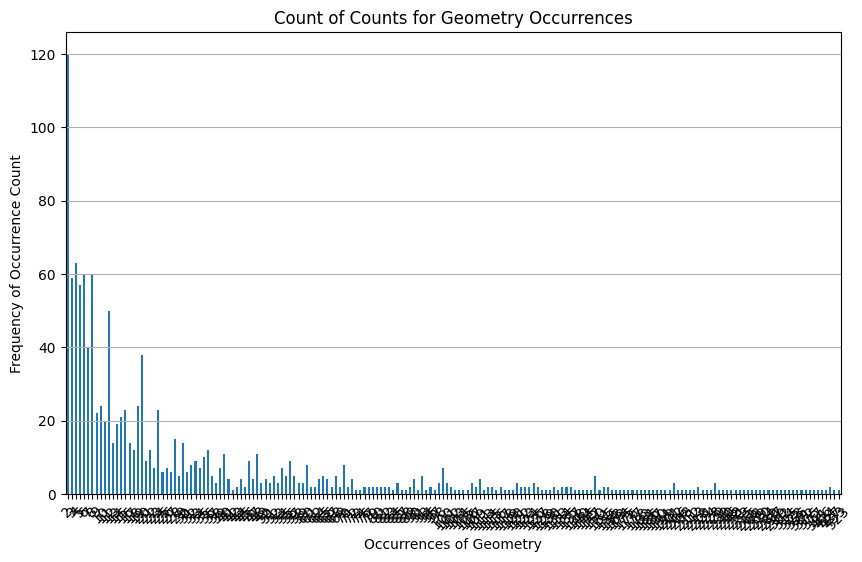

In [48]:
# Step 2: Count how many times each count occurs
count_of_counts = geometry_counts.value_counts().sort_index()

# Step 3: Print or plot the count of counts
count_of_counts = count_of_counts[1:]
count_of_counts
# visualize
# Optionally, plot the count of counts for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
count_of_counts.plot(kind='bar')
plt.title('Count of Counts for Geometry Occurrences')
plt.xlabel('Occurrences of Geometry')
plt.ylabel('Frequency of Occurrence Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [49]:
# what should we do with the duplicated geometry

In [50]:
#find min, max, mean of acre

min_acre = df['LandAcres'].min()
df['LandAcres'].describe()


count    364141.000000
mean          0.824109
std           5.443481
min           0.000000
25%           0.086800
50%           0.237600
75%           0.477500
max         679.930000
Name: LandAcres, dtype: float64

In [51]:
import geopandas as gpd

# Assuming gdf is your GeoDataFrame
gdf['geometry_wkt'] = gdf['geometry'].to_wkt()

